In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...


In [3]:
import nltk
from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk.stem import WordNetLemmatizer

is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
        	nouns.append([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2])

df["nouns"] = nouns

df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,tokenized_words,nouns
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », General, Discussion,...","[Neighbors, Forums, General, Discussion, Artic..."
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », Sports, News, », Den...","[Neighbors, Forums, Sports, News, Denver, Bron..."
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,"[Art, historian, Kelly, Grovier, looks, at, im...","[Art, historian, Kelly, Grovier, image, frame,..."


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def vectorize_texts(list_of_strings):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(list_of_strings)
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(X)
    return tfidf  

In [6]:
all_article_nouns = []
for i, element in enumerate(nouns):
    for j in range(3): #range(len(element)):
        all_article_nouns.append(element[j])

vectorized_text = vectorize_texts(all_article_nouns)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from Levenshtein import distance as levenshtein_distance

#dist = 1 - cosine_similarity(vectorized_text)
#dist

In [8]:
#Ratcliff/Obershelp Pattern Recognition
def real_quick_ratio(s1: str, s2: str) -> float:
    """Return an upper bound on ratio() very quickly."""
    l1, l2 = len(s1), len(s2)
    length = l1 + l2

    if not length:
        return 1.0

    return 2.0 * min(l1, l2) / length

In [9]:
#Ratcliff/Obershelp Pattern Recognition
def drqr_distance_calculator(stringList):
    distance_matrix = []
    for element1 in stringList:
        line = []
        for element2 in stringList:
            line.append(real_quick_ratio(element1, element2))
        distance_matrix.append(line)
    return distance_matrix

In [10]:
dist = drqr_distance_calculator(df["maintext"].tolist())
print(dist[0][0])

1.0


In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

In [12]:
np.set_printoptions(precision=4, suppress=True)
plt.figure(figsize=(10,3))
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [13]:
x = df.iloc[:, [6,7]].values
y = df.iloc[:, 8].values

In [14]:
z = linkage(dist, 'average')   #dangerous since the distance is not actually 0 on identical texts but 1.0! linkage however does only work with euklidian

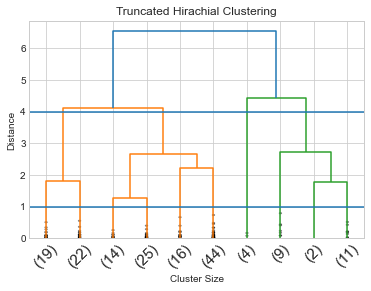

In [20]:
amount_truncate = 10
dendrogram(z, truncate_mode='lastp', p=amount_truncate, leaf_rotation=45., leaf_font_size=15., show_contracted=True)     #change p to change amount of truncated articles
plt.title("Truncated Hirachial Clustering")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")

#lines to count out clusters in the model
plt.axhline(y = 4)
plt.axhline(y = 1)

plt.show()

In [16]:
Hclustering = AgglomerativeClustering(n_clusters = amount_truncate, affinity='cosine', linkage= 'average')

Hclustering.fit(dist)

df['labels'] = Hclustering.labels_

df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,tokenized_words,nouns,labels
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », General, Discussion,...","[Neighbors, Forums, General, Discussion, Artic...",4
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », Sports, News, », Den...","[Neighbors, Forums, Sports, News, Denver, Bron...",4
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,"[Art, historian, Kelly, Grovier, looks, at, im...","[Art, historian, Kelly, Grovier, image, frame,...",2


In [17]:
cluster_topics = []

for index in range(amount_truncate):
    cluster_topics.append([])


for i, element in df.iterrows():
    label = element["labels"]
    if (len(cluster_topics[label]) > 0):
        cluster_topics[label] = set(cluster_topics[label]) & set(element["nouns"])
    else:
        cluster_topics[label] = element["nouns"]

print(cluster_topics[5])

df.head(3)

{'Features', 'Ads', 'WSJ', 'More', 'Membership', 'Jones', 'Tools', 'Customer', 'Service', 'Dow', 'Products'}


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,tokenized_words,nouns,labels
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », General, Discussion,...","[Neighbors, Forums, General, Discussion, Artic...",4
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », Sports, News, », Den...","[Neighbors, Forums, Sports, News, Denver, Bron...",4
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,"[Art, historian, Kelly, Grovier, looks, at, im...","[Art, historian, Kelly, Grovier, image, frame,...",2


In [18]:
df.head(20)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,tokenized_words,nouns,labels
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », General, Discussion,...","[Neighbors, Forums, General, Discussion, Artic...",4
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,"[Neighbors, », Forums, », Sports, News, », Den...","[Neighbors, Forums, Sports, News, Denver, Bron...",4
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,"[Art, historian, Kelly, Grovier, looks, at, im...","[Art, historian, Kelly, Grovier, image, frame,...",2
3,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:47:13",By Doc Bear (247 SPORTS) – The Denver Broncos ...,en,denver.cbslocal.com,By Doc Bear (247 SPORTS) – The Denver Broncos ...,How Jeff Holland Can Become The Broncos Next U...,https://denver.cbslocal.com/2018/07/06/jeff-ho...,"[By, Doc, Bear, (, 247, SPORTS, ), –, The, Den...","[Doc, Bear, SPORTS, Denver, Broncos, history, ...",3
4,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:35:18",How old were we when we first started playing ...,en,highschool.latimes.com,How old were we when we first started playing ...,Opinion: Are kids exposed to technology too so...,https://highschool.latimes.com/garfield-senior...,"[How, old, were, we, when, we, first, started,...","[parent, phone, Many, child, tablet, phone, pa...",2
5,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:26:30",It's the second day of school. I arrive at my ...,en,highschool.latimes.com,It's the second day of school. I arrive at my ...,Opinion: The cost of the late bus – HS Insider,https://highschool.latimes.com/richard-montgom...,"[It, 's, the, second, day, of, school, ., I, a...","[day, school, bus, stop, minute, pas, bus, tim...",3
6,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:56:36","Guided tour of historic Valletta, city of the ...",en,holidays.theguardian.com,"Guided tour of historic Valletta, city of the ...",Malta Uncovered | Guardian Holidays,https://holidays.theguardian.com/holidays/malt...,"[Guided, tour, of, historic, Valletta, ,, city...","[tour, Valletta, city, Knights, Malta, baroque...",7
7,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:52:53",3 Min Read SEOUL (Reuters) - South Korean Pres...,en,in.reuters.com,3 Min Read SEOUL (Reuters) - South Korean Pres...,South Korea pledges $39 billion emergency fun...,https://in.reuters.com/article/us-health-coron...,"[3, Min, Read, SEOUL, (, Reuters, ), -, South,...","[Min, Read, SEOUL, Reuters, President, Moon, J...",2
8,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:51:06",3 Min Read NEW YORK (Reuters) - Offshore oil d...,en,in.reuters.com,3 Min Read NEW YORK (Reuters) - Offshore oil d...,Offshore driller Valaris gears up for possibl...,https://in.reuters.com/article/us-valaris-rest...,"[3, Min, Read, NEW, YORK, (, Reuters, ), -, Of...","[Min, Read, NEW, YORK, Reuters, oil, driller, ...",2
9,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:55:19",(credit: Tee Burgess) (credit: Tee Burgess) Mi...,en,losangeles.cbslocal.com,(credit: Tee Burgess) (credit: Tee Burgess) M...,Best Ice Cream Parlors in Los Angeles – CBS Lo...,https://losangeles.cbslocal.com/top-lists/

In [19]:
print(df["maintext"][14])

14    By Jill Dougherty reporting from Beijing Under...
14    After decades of warnings about the rapidly ri...
14    Apple TV+ is about to release its latest serie...
14    3 Min Read NEW DELHI (Reuters) - A tiny Indian...
14    Shares and revenues at UK-based Audioboom are ...
14    By USA TodayNovember 23, 2016 8:07 am LEXINGTO...
Name: maintext, dtype: object
